In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Template 02
- multi-class - Fashion MNIST dataset (all 60000 images)

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score)

# from utils.helper import fn_plot_confusion_matrix

In [3]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
# Some basic parameters
inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 20 # number of cycles to run
ALPHA = 0.001 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [5]:
# train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
# test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv('fashion-mnist_train.csv', header = 0)
test_df = pd.read_csv('fashion-mnist_test.csv', header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [6]:
train_df[:10000].shape

(10000, 785)

In [7]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

Each label is an integer between 0 and 9:

In [10]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

## Whats in the data?

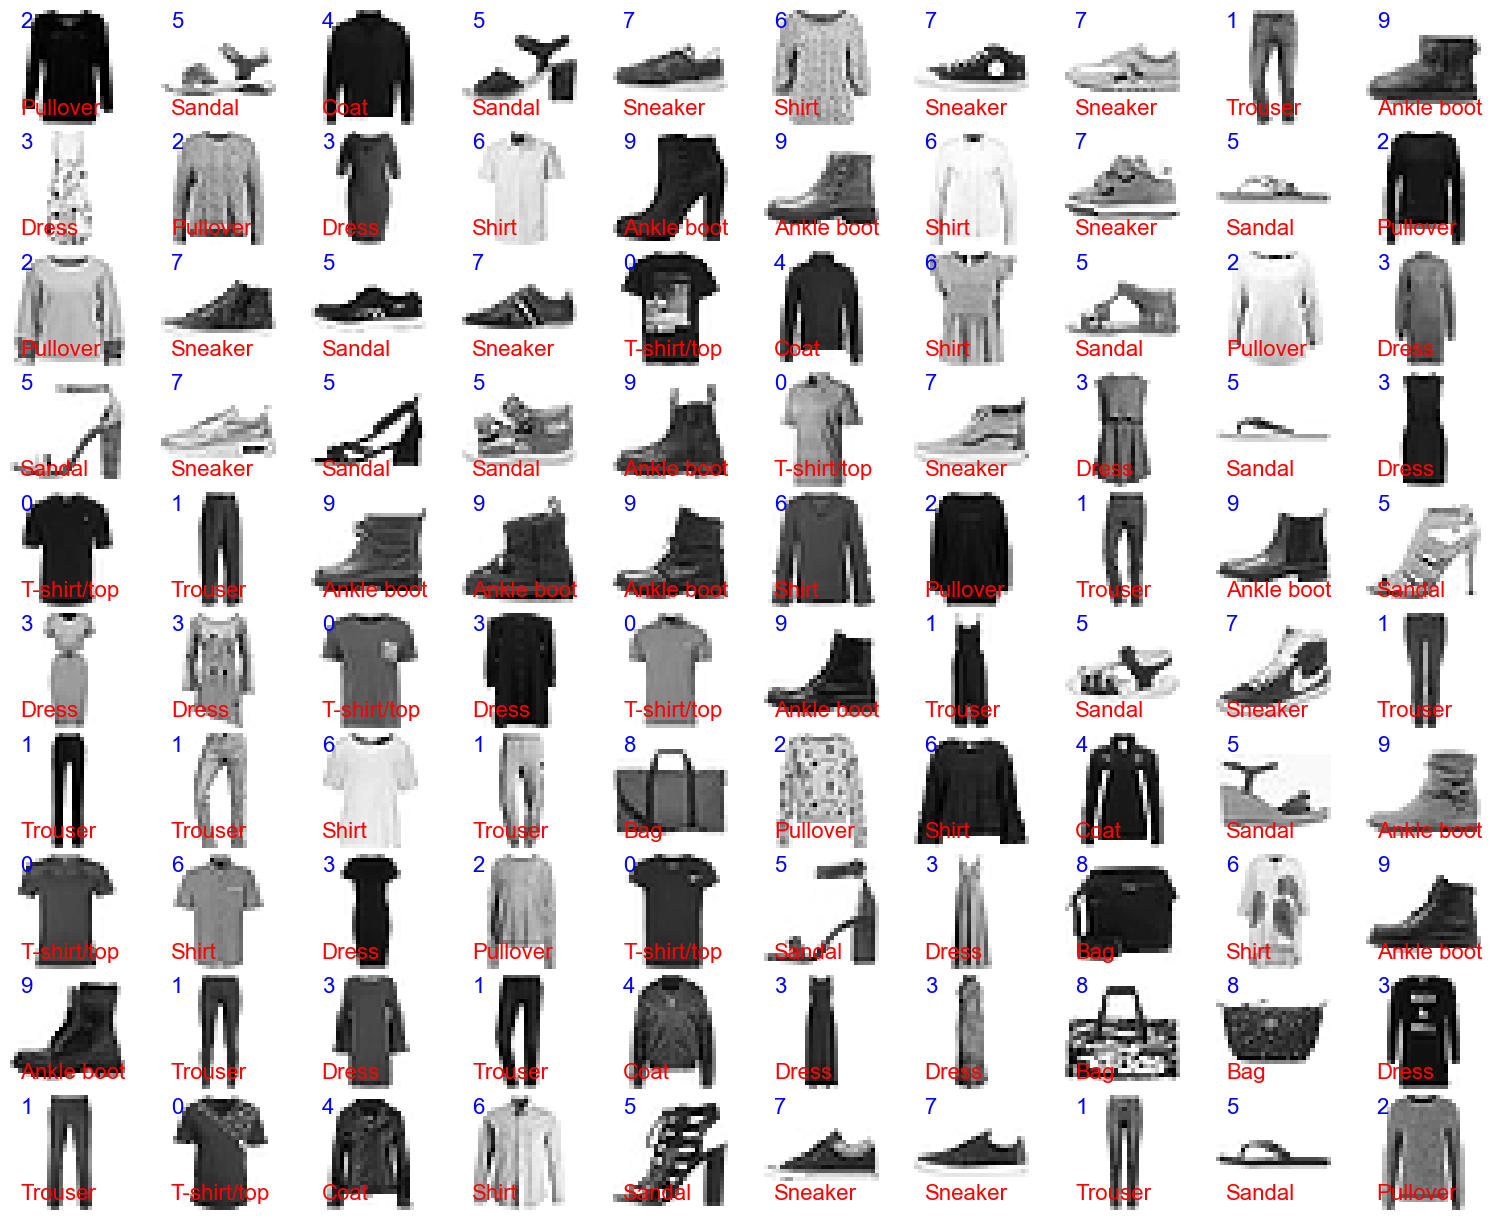

In [11]:
# Sample data plot

plot_df = train_df.sample(n = 100) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 12))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=16)   # add number (class) of the image
    
    ax.text(2, 25, class_names[row.iloc[0]], color='r', fontsize=16)   # add name of the image
    
plt.show()

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [12]:
X_train = train_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis = 1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [13]:
X_train = X_train / 255.0

X_test = X_test / 255.0

In [14]:
X_train.shape

(60000, 784)

In [ ]:
# nodes : 784, 196, 49

model = tf.keras.Sequential([
    tf.keras.Input(shape = (X_train.shape[1],)),

    tf.keras.layers.Dense(196, activation='relu'),
    tf.keras.layers.Dense(49, activation='relu'),

    tf.keras.layers.Dense(10)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 49)             │         9,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,013 (640.68 KB)

 Trainable params: 164,013 (640.68 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Step 1 :  Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Step 2 : Optimizer
#ALPHA=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Step 3 :
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# Step 4 :
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

# Defaulted BATCH_SIZE, verbose =0

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7812 - loss: 0.6212 - val_accuracy: 0.8617 - val_loss: 0.3751
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8677 - loss: 0.3594 - val_accuracy: 0.8767 - val_loss: 0.3416
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8807 - loss: 0.3238 - val_accuracy: 0.8725 - val_loss: 0.3432
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8941 - loss: 0.2819 - val_accuracy: 0.8815 - val_loss: 0.3258
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8988 - loss: 0.2672 - val_accuracy: 0.8925 - val_loss: 0.2963
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9063 - loss: 0.2509 - val_accuracy: 0.8939 - val_loss: 0.2855
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9125 - loss: 0.2343 - val_accuracy: 0.8971 - val_loss: 0.2927
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9133 - loss: 0.2261 - 

In [17]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.826783,0.480064,0.8617,0.375133
1,0.869400,0.352601,0.8767,0.341622
2,0.883100,0.315776,0.8725,0.343184
3,0.892400,0.287966,0.8815,0.325779
4,0.897950,0.269537,0.8925,0.296312


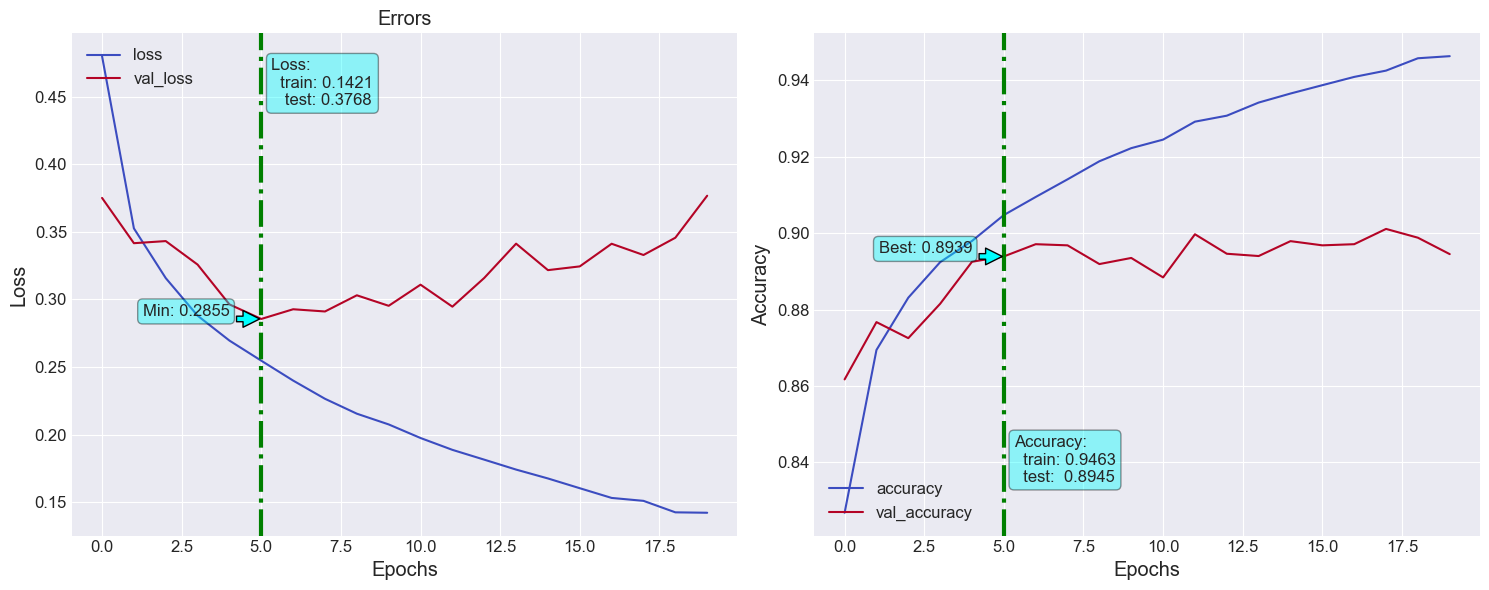

In [18]:
fn_plot_tf_hist(loss_df)

In [19]:
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred = model.predict(X_test).argmax(axis=1)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


In [20]:
accuracy_score(y_train, y_train_pred)

0.9482666666666667

In [21]:
print(f'Accuracy: {accuracy_score(y_test, y_test_pred): .4f}')

Accuracy:  0.8945


In [22]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1000
           1       0.98      0.99      0.99      1000
           2       0.82      0.81      0.82      1000
           3       0.94      0.89      0.92      1000
           4       0.85      0.83      0.84      1000
           5       0.99      0.94      0.96      1000
           6       0.72      0.71      0.71      1000
           7       0.93      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [23]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[874,   1,  20,  11,   0,   1,  87,   0,   6,   0],
       [  5, 987,   2,   5,   0,   1,   0,   0,   0,   0],
       [ 21,   0, 814,   7,  65,   1,  86,   0,   6,   0],
       [ 31,  13,   5, 893,  34,   1,  20,   0,   3,   0],
       [  3,   2,  78,  19, 828,   1,  66,   0,   3,   0],
       [  0,   0,   1,   0,   0, 936,   0,  40,   1,  22],
       [159,   1,  68,  13,  46,   0, 706,   0,   7,   0],
       [  0,   0,   0,   0,   0,   2,   0, 965,   0,  33],
       [  1,   0,   5,   1,   2,   5,  10,   2, 972,   2],
       [  0,   0,   0,   0,   0,   2,   0,  28,   0, 970]], dtype=int64)

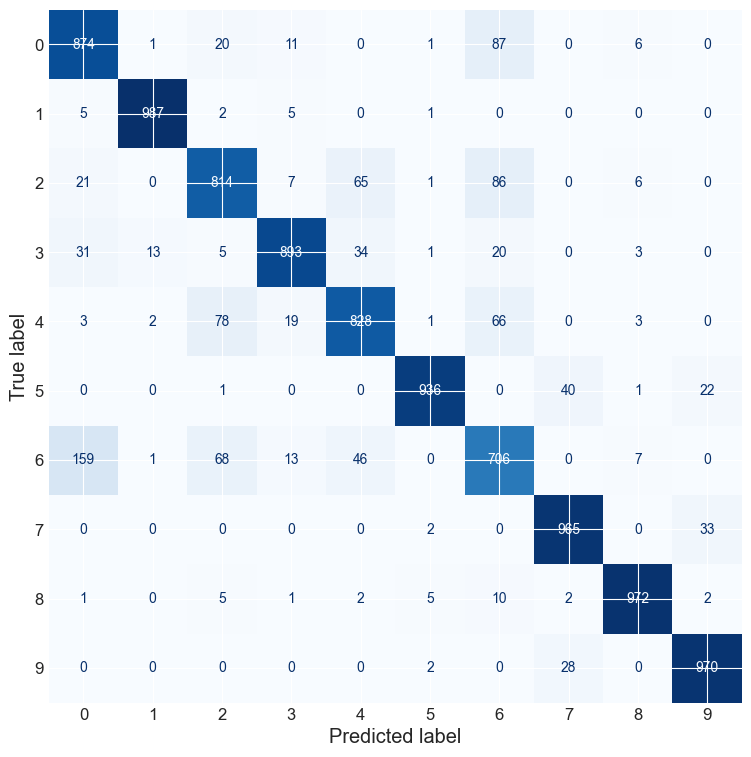

In [24]:
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap= 'Blues',colorbar = False)

In [25]:
f1_score(y_test, y_test_pred, average='weighted')

0.8944895383233948

#### L2 Regularization

In [26]:
regularization = tf.keras.regularizers.L2(0.01)

In [27]:
# nodes : 784, 196, 49

model1 = tf.keras.Sequential([
    tf.keras.Input(shape = (784,)),

    tf.keras.layers.Dense(196, kernel_regularizer=regularization, activation='relu'),
    tf.keras.layers.Dense(49, kernel_regularizer=regularization, activation='relu'),

    tf.keras.layers.Dense(10)
])

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 49)             │         9,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,013 (640.68 KB)

 Trainable params: 164,013 (640.68 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Step 1 :  Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Step 2 : Optimizer
#ALPHA=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Step 3 :
model1.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# Step 4 :
history = model1.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

# Defaulted BATCH_SIZE, verbose =0

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7528 - loss: 1.6323 - val_accuracy: 0.7852 - val_loss: 0.8100
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7997 - loss: 0.7533 - val_accuracy: 0.8178 - val_loss: 0.6814
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8138 - loss: 0.6837 - val_accuracy: 0.8354 - val_loss: 0.6323
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8255 - loss: 0.6378 - val_accuracy: 0.8343 - val_loss: 0.6076
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8266 - loss: 0.6216 - val_accuracy: 0.8341 - val_loss: 0.5977
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8318 - loss: 0.5974 - val_accuracy: 0.8352 - val_loss: 0.5822
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8341 - loss: 0.5817 - val_accuracy: 0.8387 - val_loss: 0.5790
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8373 - loss: 0.5684 - 

In [29]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.784400,1.067037,0.7852,0.810023
1,0.804233,0.730097,0.8178,0.681351
2,0.814283,0.674931,0.8354,0.632276
3,0.822700,0.639446,0.8343,0.607638
4,0.829117,0.614199,0.8341,0.597679


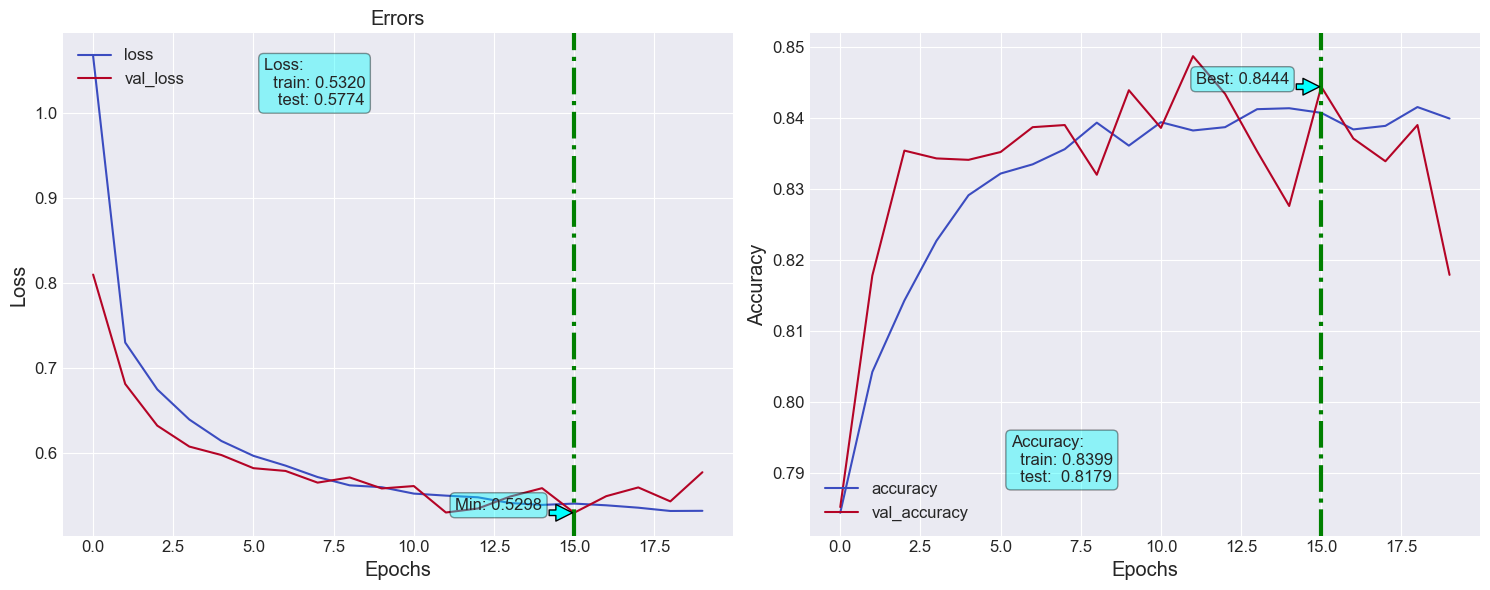

In [30]:
fn_plot_tf_hist(loss_df)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


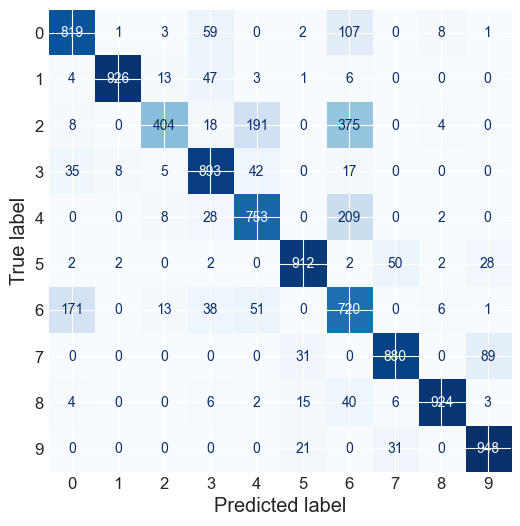

In [32]:
y_train_pred = model1.predict(X_train).argmax(axis=1)
y_test_pred = model1.predict(X_test).argmax(axis=1)
fig, ax = plt.subplots(figsize = (15,6))
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap= 'Blues', ax=ax, colorbar = False)

In [33]:
del model
del model1

In [117]:
dor1 = 0.2
dor2 = 0.3
dor3 = 0.1

model2 = tf.keras.Sequential([
    tf.keras.Input(shape = (X_train.shape[1],)),
    # tf.keras.layers.Dropout(rate=dor1, seed = RANDOM_STATE),
    tf.keras.layers.Dense(196, activation='relu'),
    tf.keras.layers.Dropout(rate=dor2, seed = RANDOM_STATE),
    tf.keras.layers.Dense(49, activation='relu'),
    tf.keras.layers.Dropout(rate=dor3, seed = RANDOM_STATE),
    tf.keras.layers.Dense(10)
])

model2.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 49)             │         9,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,013 (640.68 KB)

 Trainable params: 164,013 (640.68 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
# Step 1 :  Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Step 2 : Optimizer
#ALPHA=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Step 3 :
model2.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# Step 4 :
history = model2.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

# Defaulted BATCH_SIZE, verbose =0

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7110 - loss: 0.8017 - val_accuracy: 0.8496 - val_loss: 0.4096
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8343 - loss: 0.4590 - val_accuracy: 0.8622 - val_loss: 0.3789
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8489 - loss: 0.4187 - val_accuracy: 0.8733 - val_loss: 0.3452
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8559 - loss: 0.3928 - val_accuracy: 0.8785 - val_loss: 0.3340
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8638 - loss: 0.3775 - val_accuracy: 0.8751 - val_loss: 0.3392
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8659 - loss: 0.3670 - val_accuracy: 0.8784 - val_loss: 0.3311
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8722 - loss: 0.3496 - val_accuracy: 0.8804 - val_loss: 0.3289
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8772 - loss: 0.3385 - 

In [119]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.780983,0.611005,0.8496,0.409579
1,0.839367,0.446824,0.8622,0.378900
2,0.849183,0.414427,0.8733,0.345159
3,0.856767,0.391743,0.8785,0.333956
4,0.865167,0.373992,0.8751,0.339213


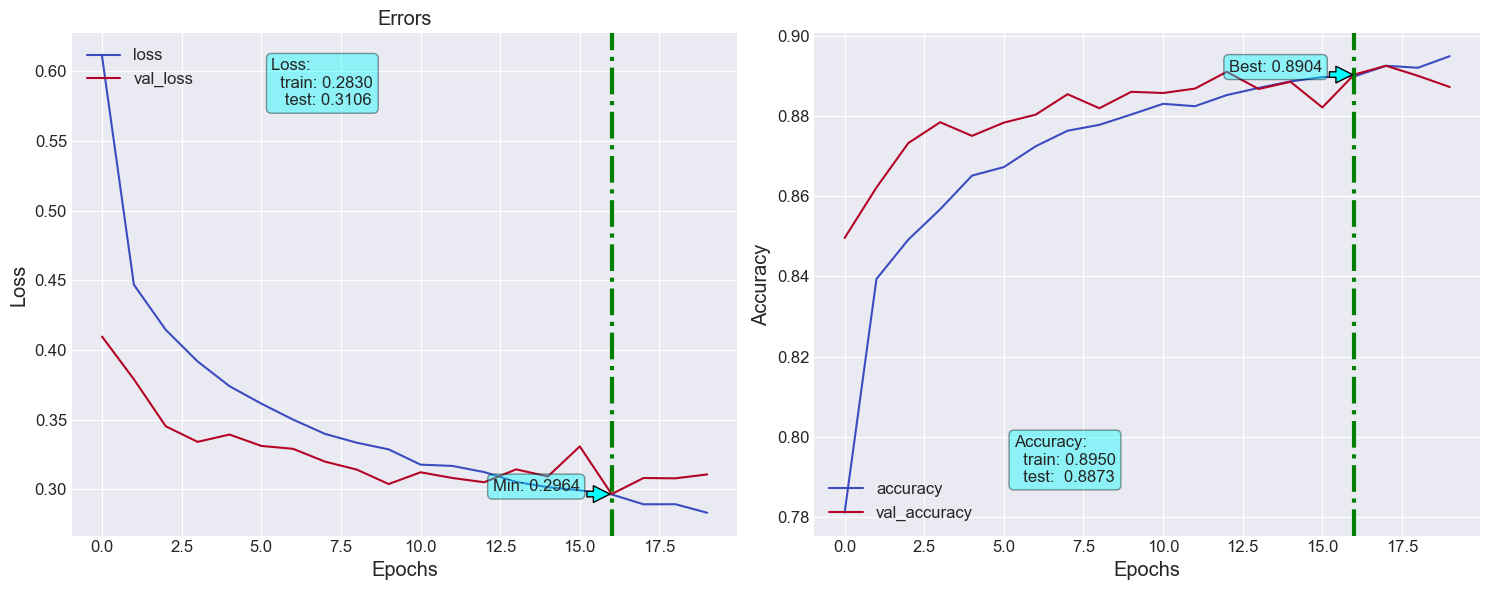

In [120]:
fn_plot_tf_hist(loss_df)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


Text(0.5, 1.0, '0.3/0.1')

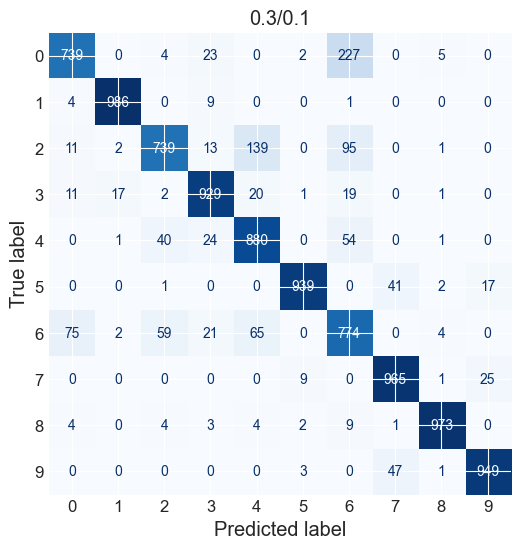

In [121]:
y_train_pred = model2.predict(X_train).argmax(axis=1)
y_test_pred = model2.predict(X_test).argmax(axis=1)
fig, ax = plt.subplots(figsize = (15,6))
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap= 'Blues', ax=ax, colorbar = False)
ax.set_title('0.3/0.1')

In [122]:
f1_score(y_test, y_test_pred, average='weighted')

0.8878589161385139

In [ ]:
# dor1 = 0.2
# dor2 = 0.3
# dor3 = 0.1

# model3 = tf.keras.Sequential([
#     tf.keras.Input(shape = (X_train.shape[1],)),
#     # tf.keras.layers.Dropout(rate=dor1, seed = RANDOM_STATE),
#     tf.keras.layers.Dense(196),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),
    
#     tf.keras.layers.Dropout(rate=dor2, seed = RANDOM_STATE),
#     tf.keras.layers.Dense(49),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),
#     tf.keras.layers.Dropout(rate=dor3, seed = RANDOM_STATE),
#     tf.keras.layers.Dense(10)
# ])

# model3.summary()

### call backs

In [125]:
chkpt_filepath = f'{altName}.weights.h5'
chkpt_filepath


'all_in.weights.h5'

In [128]:
tf.keras.callbacks.ReduceLROnPlateau?

Init signature:
tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
    **kwargs,
)
Docstring:     
Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor
of 2-10 once learning stagnates. This callback monitors a
quantity and if no improvement is seen for a 'patience' number
of epochs, the learning rate is reduced.

Example:

```python
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model.fit(x_train, y_train, callbacks=[reduce_lr])
```

Args:
    monitor: String. Quantity to be monitored.
    factor: Float. Factor by which the learning rate will be reduced.
        `new_lr = lr * factor`.
    patience: Integer. Number of epochs with no improvement after which
        learning rate will be reduced.
    verbose: Integer. 0:

In [129]:
EPOCHS = 500
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

model_chkpt = tf.keras.callbacks.ModelCheckpoint(
    chkpt_filepath,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
)

escb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=2,
    restore_best_weights=True
)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    min_lr=1e-5
)

In [130]:
# Step 1 :  Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Step 2 : Optimizer
#ALPHA=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Step 3 :
model2.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# Step 4 :
history = model2.fit(X_train, y_train,callbacks = [model_chkpt, escb, lrcb], 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

# Defaulted BATCH_SIZE, verbose =0

Epoch 1/500
1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8943 - loss: 0.2800
Epoch 1: val_loss improved from inf to 0.29977, saving model to all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8943 - loss: 0.2800 - val_accuracy: 0.8917 - val_loss: 0.2998 - learning_rate: 0.0010
Epoch 2/500
1831/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8976 - loss: 0.2741
Epoch 2: val_loss improved from 0.29977 to 0.29862, saving model to all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8975 - loss: 0.2742 - val_accuracy: 0.8936 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 3/500
1856/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8963 - loss: 0.2782
Epoch 3: val_loss improved from 0.29862 to 0.29202, saving model to all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8963 - loss: 0.2782 - val_accuracy: 0.8962 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 4/500
1846/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [131]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.894783,0.281639,0.8917,0.299774,0.001
1,0.896000,0.277944,0.8936,0.298623,0.001
2,0.895917,0.279062,0.8962,0.292016,0.001
3,0.896533,0.277198,0.8929,0.307144,0.001
4,0.897700,0.273041,0.8935,0.300296,0.001


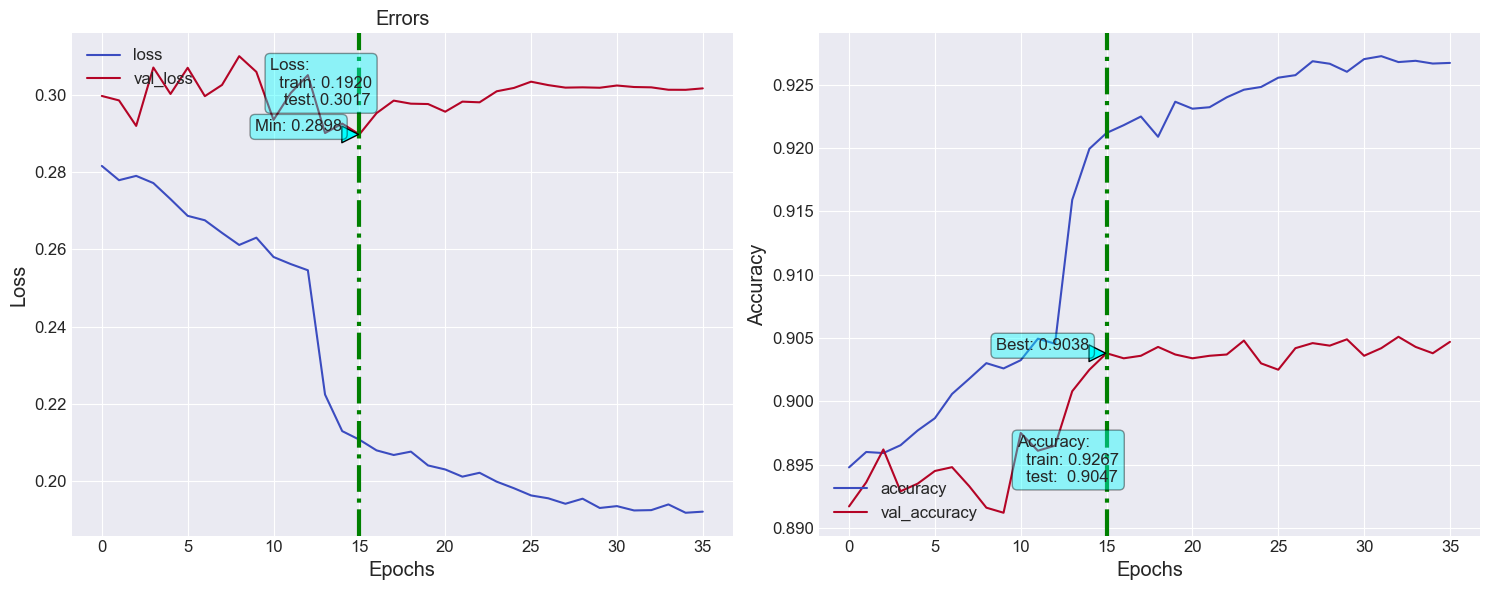

In [132]:
fn_plot_tf_hist(loss_df)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


Text(0.5, 1.0, '0.3/0.1')

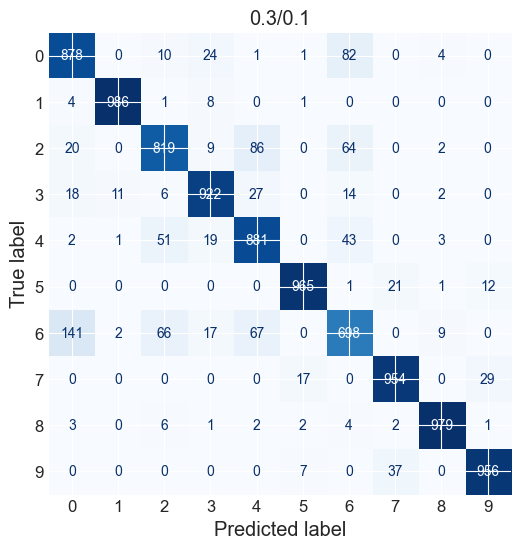

In [133]:
y_train_pred = model2.predict(X_train).argmax(axis=1)
y_test_pred = model2.predict(X_test).argmax(axis=1)
fig, ax = plt.subplots(figsize = (15,6))
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap= 'Blues', ax=ax, colorbar = False)
ax.set_title('0.3/0.1')

In [134]:
f1_score(y_test, y_test_pred, average='weighted')

0.9031913321268745

### Final Model 

In [ ]:
dor1 = 0.2
dor2 = 0.3
dor3 = 0.1

model3 = tf.keras.Sequential([
    tf.keras.Input(shape = (X_train.shape[1],)),
    # tf.keras.layers.Dropout(rate=dor1, seed = RANDOM_STATE),   # dropping 1st dropout layer
    tf.keras.layers.Dense(196),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.Dropout(rate=dor2, seed = RANDOM_STATE),
    tf.keras.layers.Dense(49),                     
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(rate=dor3, seed = RANDOM_STATE),
    tf.keras.layers.Dense(10)                      # notice absence of softmax function
])

model3.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 196)            │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 49)             │         9,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 49)             │           196 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,993 (644.50 KB)

 Trainable params: 164,503 (642.59 KB)

 Non-trainable params: 490 (1.91 KB)

In [142]:
chkpt_filepath = f'{altName}.weights.h5'

In [143]:
EPOCHS = 500
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

model_chkpt = tf.keras.callbacks.ModelCheckpoint(
    chkpt_filepath,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
)

escb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=2,
    restore_best_weights=True
)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    min_lr=1e-5
)

In [144]:
# Step 1 :  Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Step 2 : Optimizer
#ALPHA=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Step 3 :
model3.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# Step 4 :
history = model3.fit(X_train, y_train,callbacks = [model_chkpt, escb, lrcb], 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

# Defaulted BATCH_SIZE, verbose =0

Epoch 1/500
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7620 - loss: 0.7062
Epoch 1: val_loss improved from inf to 0.41723, saving model to all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7621 - loss: 0.7061 - val_accuracy: 0.8466 - val_loss: 0.4172 - learning_rate: 0.0010
Epoch 2/500
1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8447 - loss: 0.4322
Epoch 2: val_loss improved from 0.41723 to 0.37304, saving model to all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8447 - loss: 0.4322 - val_accuracy: 0.8608 - val_loss: 0.3730 - learning_rate: 0.0010
Epoch 3/500
1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8541 - loss: 0.4046
Epoch 3: val_loss improved from 0.37304 to 0.34738, saving model to all_in.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8541 - loss: 0.4045 - val_accuracy: 0.8727 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 4/500
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [145]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.804133,0.560528,0.8466,0.417226,0.001
1,0.845550,0.429870,0.8608,0.373042,0.001
2,0.855483,0.397776,0.8727,0.347382,0.001
3,0.863200,0.376474,0.8819,0.326663,0.001
4,0.868467,0.359296,0.8811,0.319035,0.001


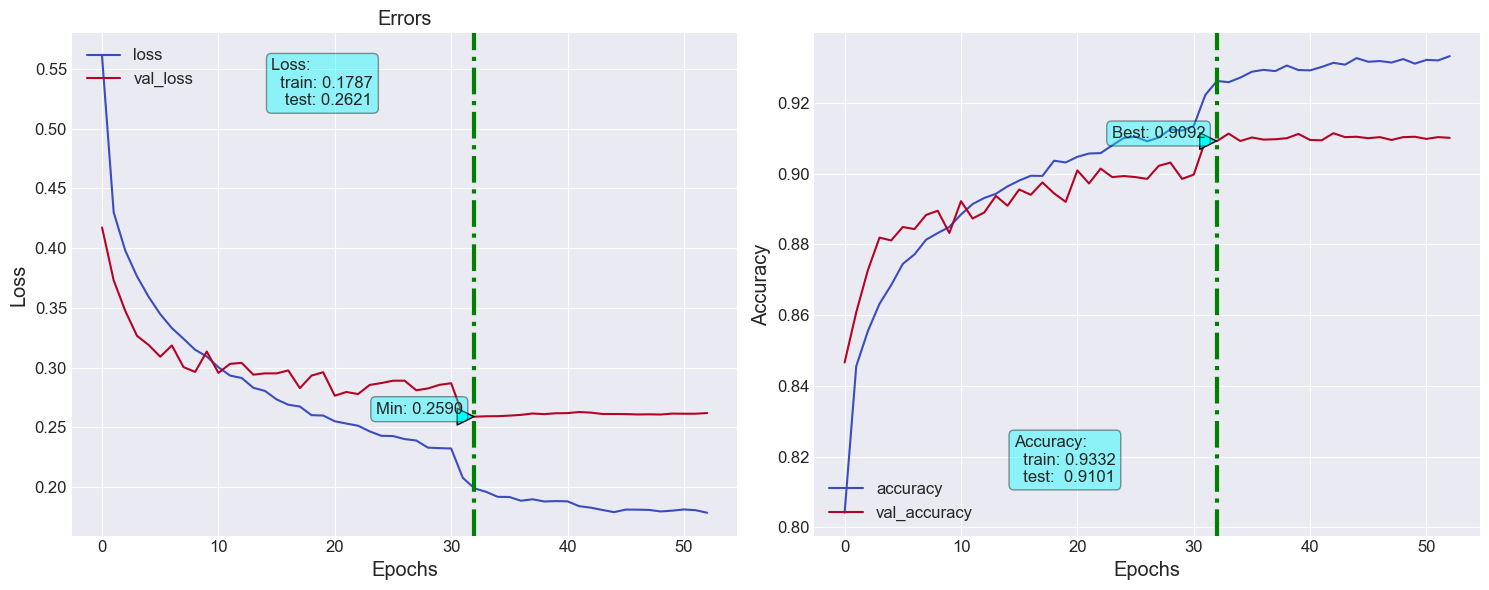

In [146]:
fn_plot_tf_hist(loss_df)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


Text(0.5, 1.0, '0.3/0.1')

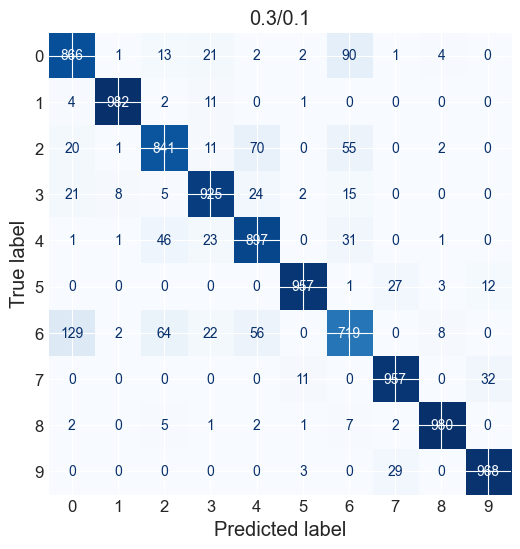

In [147]:
y_train_pred = model3.predict(X_train).argmax(axis=1)
y_test_pred = model3.predict(X_test).argmax(axis=1)
fig, ax = plt.subplots(figsize = (15,6))
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap= 'Blues', ax=ax, colorbar = False)
ax.set_title('0.3/0.1')

In [148]:
# Calculate F1 score of final model
f1_score(y_test, y_test_pred, average='weighted')

0.9087199121814347